In [1]:
import subprocess
import os
import pandas as pd
import numpy as np
from typing import Tuple
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:
def remove_invalid_values(simulated, observed):
    valid_indices = np.where((observed != -9999) & (simulated != -9999))
    return simulated[valid_indices], observed[valid_indices]


In [3]:
def remove_nan_rows(
    array1: np.ndarray, 
    array2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Removes rows from two arrays where either array has NaN values.
    Retains the first row if it doesn't have any NaN values.
    
    Arguments:
    array1: np.ndarray:
        First input array
    array2: np.ndarray
        Second input array
    
    Returns:
    cleaned_array1: : np.ndarray
        Cleaned array1 without NaN rows
    cleaned_array2: np.ndarray
        Cleaned array2 without NaN rows
    """
    # checks for and removes any rows where either array has a value of NaN at a corresponding row 
    # including the first one
    
    mask = np.logical_and(~np.isnan(array1), ~np.isnan(array2))
    if not np.isnan(array1[0]) and not np.isnan(array2[0]):
        mask[0] = True
    cleaned_array1 = array1[mask]
    cleaned_array2 = array2[mask]
    return cleaned_array1, cleaned_array2

In [4]:
def compute_kge(simulated_array, observed_array):
    """
    Computes KGE (Kling-Gupta Efficiency) between observed and simulated values.

    Parameters:
        observed_array (numpy.ndarray): Array of observed values.
        simulated_array (numpy.ndarray): Array of simulated values.

    Returns:
        float: KGE value.
    """
    
    # Calculate Pearson correlation coefficient
    correlation_coefficient = np.corrcoef(observed_array, simulated_array)[0, 1]
    
    # Calculate standard deviation ratio
    std_observed = np.std(observed_array)
    std_simulated = np.std(simulated_array)
    std_ratio = std_simulated / std_observed
    
    # Calculate bias ratio
    mean_observed = np.mean(observed_array)
    mean_simulated = np.mean(simulated_array)
    bias_ratio = mean_simulated / mean_observed
    
    # Calculate KGE
    kge = 1 - np.sqrt((correlation_coefficient - 1)**2 + (std_ratio - 1)**2 + (bias_ratio - 1)**2)
    
    return kge

In [5]:
# Directory where Hype outputs are saved
file_path= "../../model/model_versions/v_8/v8_0/results/"

In [6]:
calibration_ranges = [('1980-10-01', '1984-09-30'),
               ('1989-10-01', '1998-09-30'),
               ('2003-10-01', '2007-09-30'),
               ('2012-10-01', '2015-09-30')]

In [7]:
validation_ranges = [('1984-10-01', '1989-09-30'),
               ('1998-10-01', '2003-09-30'),
               ('2007-10-01', '2010-09-30')]

In [8]:
# Initialize an empty DataFrame to store results
results_df = pd.DataFrame()

In [9]:
# Iterate through files in the output directory
for filename in os.listdir(file_path):
    if filename.endswith(".txt") and filename.startswith("00"):  # Process files with prefix '00' and end with '.txt'
        filepath = os.path.join(file_path, filename)
        
        # Read tab-separated file into DataFrame
        flow = pd.read_csv(filepath, sep='\t', index_col=0)
        flow = flow.iloc[1:]  # Drop the first row
        
        calibration_kge = []
        validation_kge = []
        cal_mean_rout = []
        val_mean_rout = []

        # Process and filter DataFrame based on calibration period
        for start_date, end_date in calibration_ranges:
            trimmed_df = flow.loc[start_date:end_date]
            
            cal_sim = trimmed_df['cout'].values.astype(float)
            cal_obs = trimmed_df['rout'].values.astype(float)

            simulated_array_cal, observed_array_cal = remove_invalid_values(cal_sim, cal_obs)
            
            cal_kge = compute_kge(simulated_array_cal, observed_array_cal)
            calibration_kge.append(cal_kge)
            
            # Calculate mean rout flow for the calibration period
            mean_rout_cal = observed_array_cal.mean()
            cal_mean_rout.append(mean_rout_cal)

        # Process and filter DataFrame based on validation period
        for start_date, end_date in validation_ranges:
            trimmed_df = flow.loc[start_date:end_date]
            
            val_sim = trimmed_df['cout'].values.astype(float)
            val_obs = trimmed_df['rout'].values.astype(float)

            simulated_array_val, observed_array_val = remove_invalid_values(val_sim, val_obs)
            
            val_kge = compute_kge(simulated_array_val, observed_array_val)
            validation_kge.append(val_kge)
            
            # Calculate mean rout flow for the validation period
            mean_rout_val = observed_array_val.mean()
            val_mean_rout.append(mean_rout_val)

        # Create a Series to store KGE values and mean rout values with year ranges as columns
        kge_series = pd.Series(
            data=calibration_kge + validation_kge + cal_mean_rout + val_mean_rout,
            index=[f'Cal_KGE_{start}-{end}' for start, end in calibration_ranges] +
                  [f'Val_KGE_{start}-{end}' for start, end in validation_ranges] +
                  [f'Cal_Mean_Rout_{start}-{end}' for start, end in calibration_ranges] +
                  [f'Val_Mean_Rout_{start}-{end}' for start, end in validation_ranges],
            name=filename
        )
        
        # Concatenate the Series to the results DataFrame
        results_df = pd.concat([results_df, kge_series.to_frame().T])

C:\Users\Paul Coderre\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Paul Coderre\anaconda3\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\Paul Coderre\anaconda3\lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Paul Coderre\anaconda3\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\Paul Coderre\anaconda3\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Paul Coderre\anaconda3\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof

In [10]:
kge_series

Cal_KGE_1980-10-01-1984-09-30          0.407589
Cal_KGE_1989-10-01-1998-09-30          0.382186
Cal_KGE_2003-10-01-2007-09-30          0.312022
Cal_KGE_2012-10-01-2015-09-30          0.274884
Val_KGE_1984-10-01-1989-09-30          0.269610
Val_KGE_1998-10-01-2003-09-30          0.254163
Val_KGE_2007-10-01-2010-09-30          0.052007
Cal_Mean_Rout_1980-10-01-1984-09-30    0.506543
Cal_Mean_Rout_1989-10-01-1998-09-30    0.888389
Cal_Mean_Rout_2003-10-01-2007-09-30    0.459950
Cal_Mean_Rout_2012-10-01-2015-09-30    0.606826
Val_Mean_Rout_1984-10-01-1989-09-30    0.344767
Val_Mean_Rout_1998-10-01-2003-09-30    0.556908
Val_Mean_Rout_2007-10-01-2010-09-30    0.775502
Name: 0058643.txt, dtype: float64

In [11]:
# Index values of rows to drop
rows_to_drop = ['0058208.txt', '0058213.txt', '0058223.txt']

# Drop the specified rows
filtered_df = results_df.drop(index=rows_to_drop)

In [12]:
filtered_df.to_csv('../../model/model_versions/v_8/v8_0/kge_in_depth_.csv')
filtered_df

,Cal_KGE_1980-10-01-1984-09-30,Cal_KGE_1989-10-01-1998-09-30,Cal_KGE_2003-10-01-2007-09-30,Cal_KGE_2012-10-01-2015-09-30,Val_KGE_1984-10-01-1989-09-30,Val_KGE_1998-10-01-2003-09-30,Val_KGE_2007-10-01-2010-09-30,Cal_Mean_Rout_1980-10-01-1984-09-30,Cal_Mean_Rout_1989-10-01-1998-09-30,Cal_Mean_Rout_2003-10-01-2007-09-30,Cal_Mean_Rout_2012-10-01-2015-09-30,Val_Mean_Rout_1984-10-01-1989-09-30,Val_Mean_Rout_1998-10-01-2003-09-30,Val_Mean_Rout_2007-10-01-2010-09-30
0058290.txt,0.248778,0.267020,0.274733,0.473127,0.308769,0.017129,-0.971348,2.229079,3.718100,2.423607,4.628478,2.488458,2.359802,2.017069
0058308.txt,0.362604,0.138850,0.500410,0.085611,-0.148987,0.224871,0.111517,3.992720,8.227472,3.157440,5.340178,3.021247,4.507177,6.810954
0058328.txt,0.303026,0.171006,0.073322,0.853775,-0.086729,0.046210,0.150240,1.495257,0.962584,1.021653,2.758602,3.281575,0.563936,1.755390
0058346.txt,-7.934483,0.330240,-0.032561,0.813870,-1.390551,-16.457951,0.432730,0.056843,0.817835,0.395833,1.184134,0.634933,0.057892,1.782172
0058356.txt,-0.152667,0.081768,-0.398701,0.052471,0.374932,-0.598289,-2.569072,0.540841,1.244101,0.409740,0.733196,1.431710,0.390014,0.770771
0058363.txt,0.307175,0.266880,-0.066662,0.325742,0.497767,-0.424792,-0.858546,0.819964,1.408526,0.837473,1.017364,1.436321,0.679021,1.403654
0058398.txt,0.138354,0.227349,-0.069267,0.360986,0.132350,0.229174,0.436163,0.375774,0.394454,0.273914,0.631953,0.373535,0.398252,0.264468
0058408.txt,0.378123,0.493003,0.685913,0.232859,0.404290,0.622845,0.043973,1.666437,3.484402,1.457930,2.277061,1.670873,2.144395,3.100805
0058418.txt,0.150144,0.157076,0.046307,NaN,0.396077,-0.885475,0.370551,0.881933,0.889107,0.458269,NaN,1.704466,0.179023,1.132915
0058425.txt,-24.637653,0.240541,0.144287,0.754710,-0.150694,-2.324762,-0.023324,0.010623,0.401351,0.334766,1.065172,0.443234,0.106196,1.287495


C:\Users\Paul Coderre\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\Paul Coderre\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\Paul Coderre\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


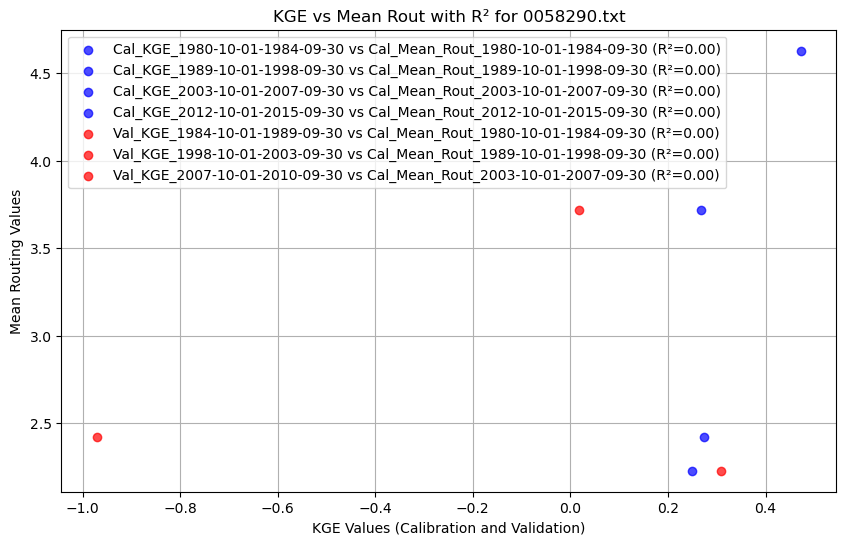

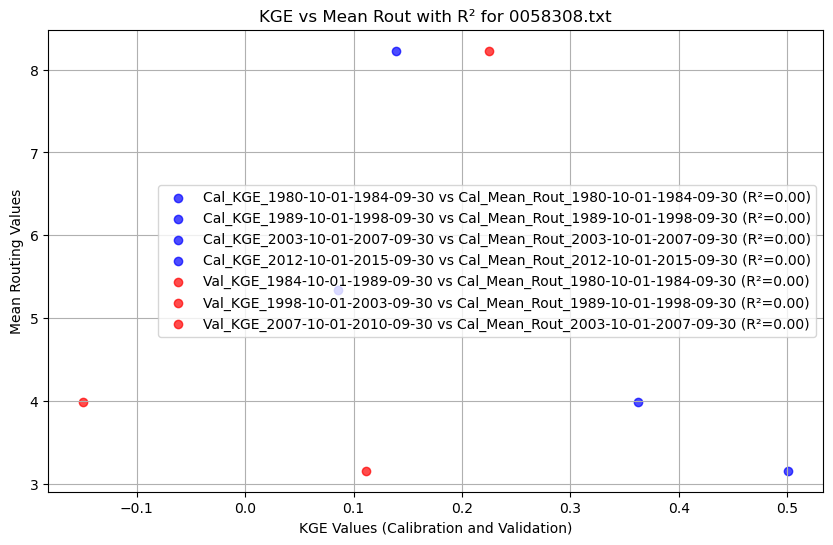

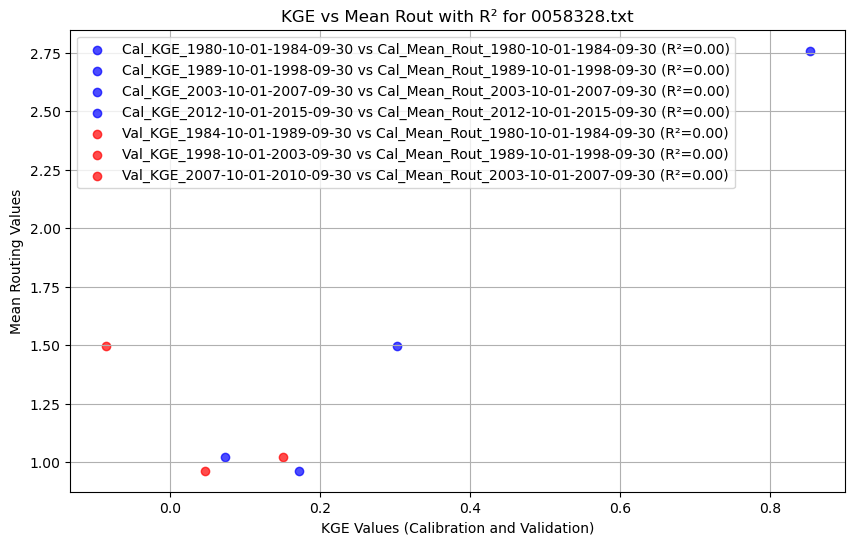

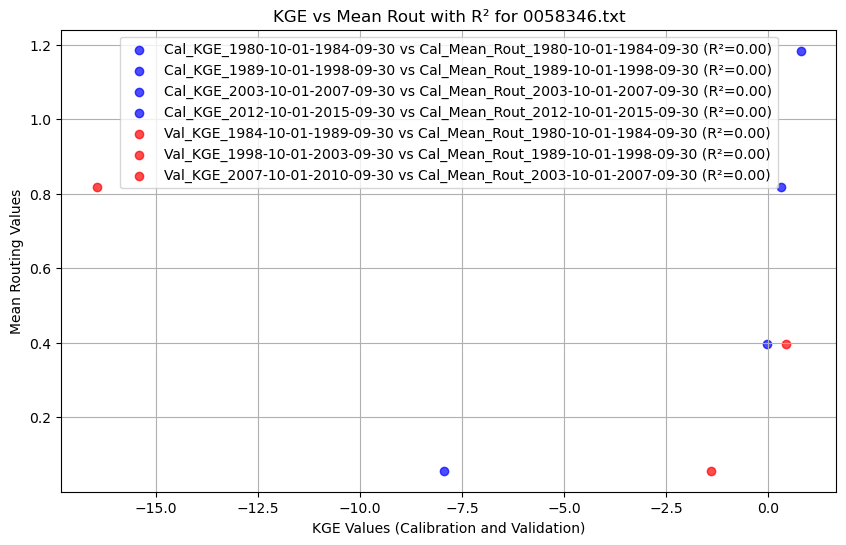

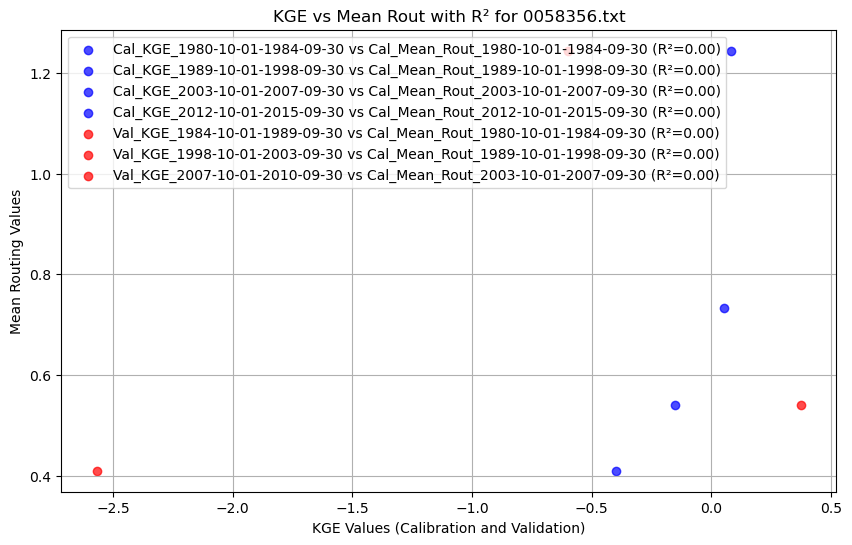

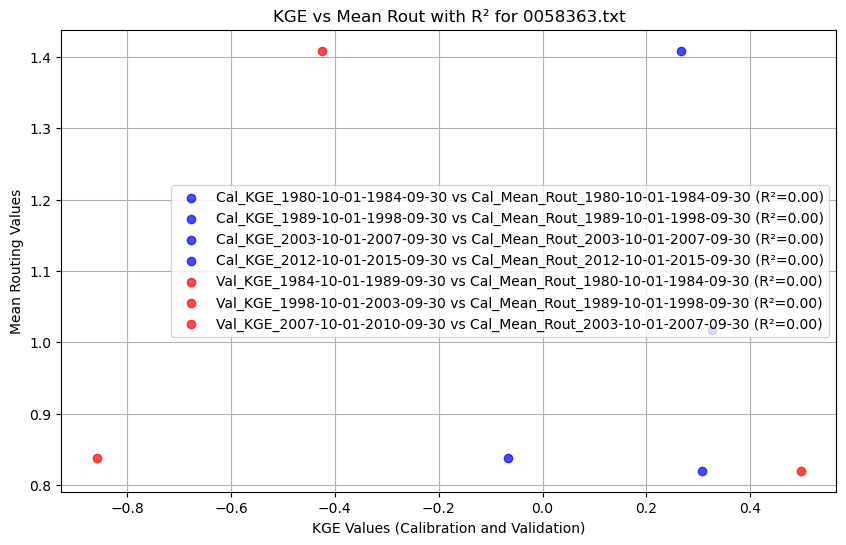

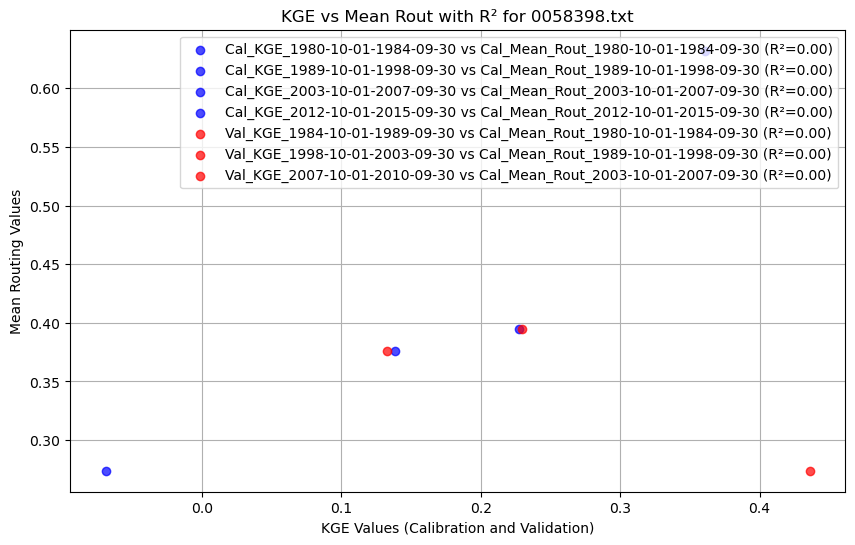

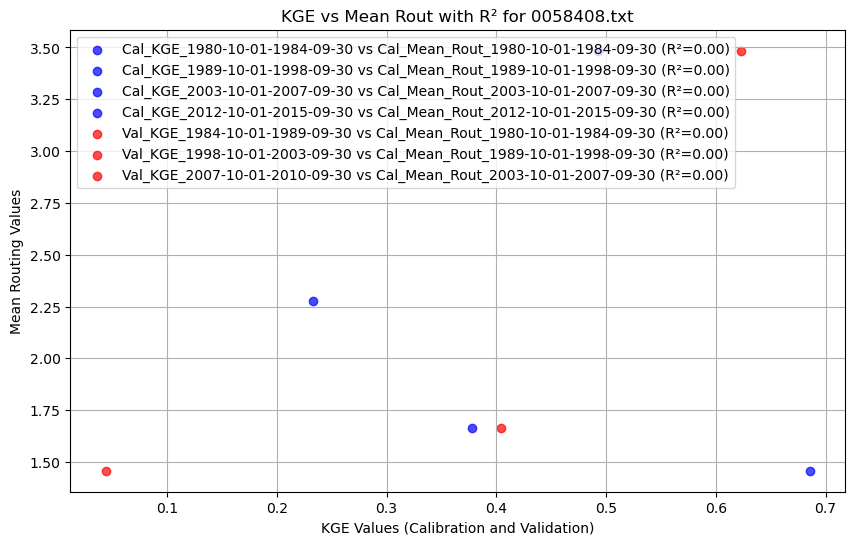

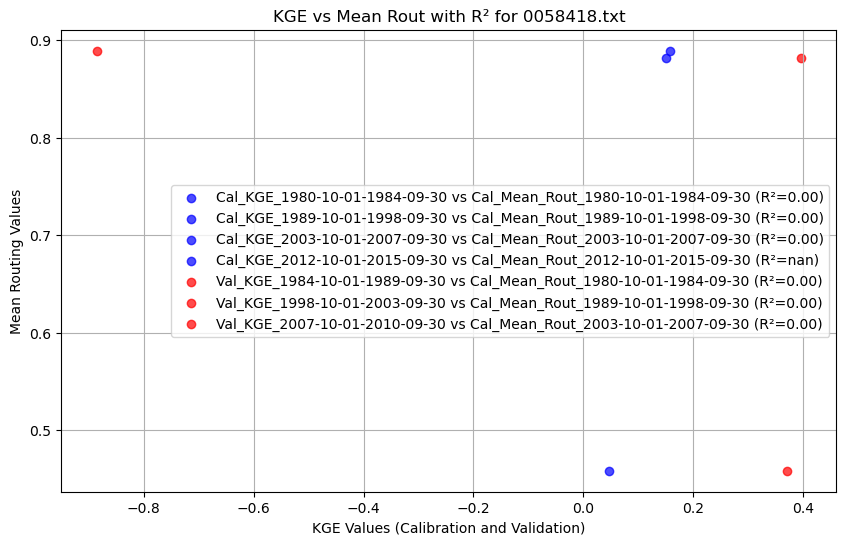

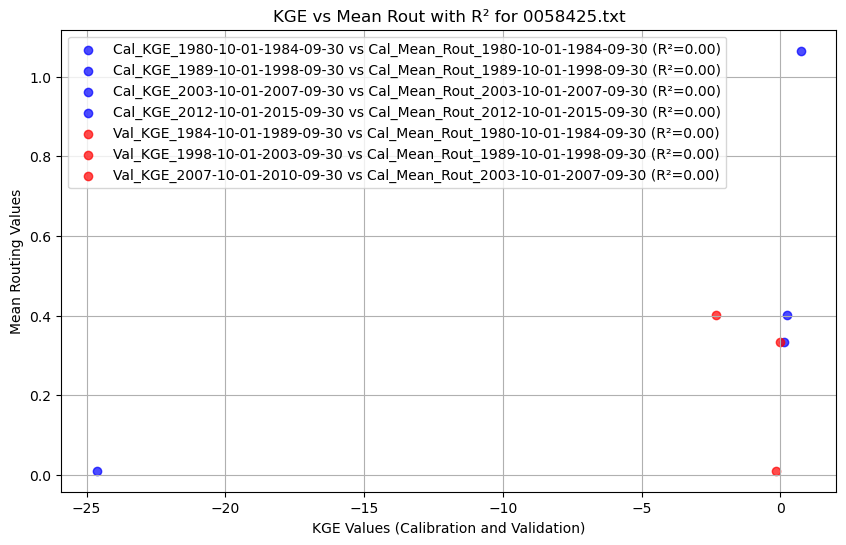

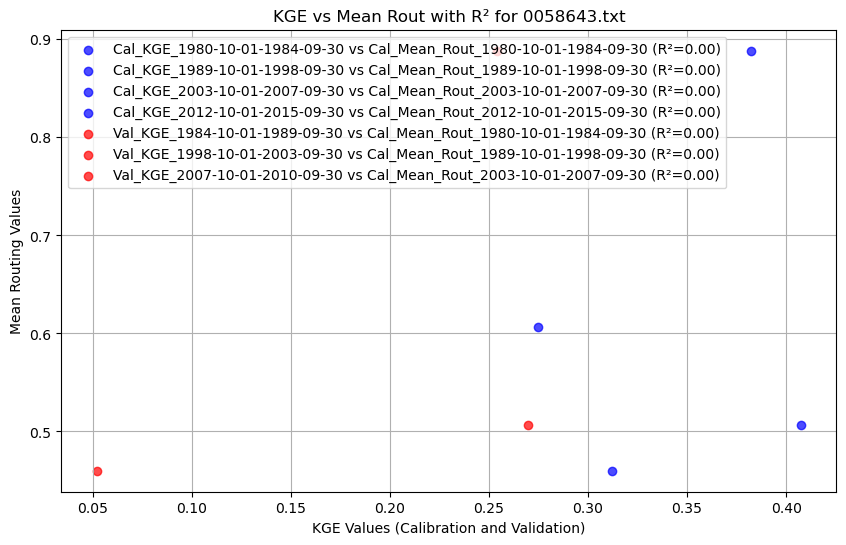

In [13]:

# Function to calculate R^2
def calculate_r2(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value**2

# Define the column pairs for KGE and Mean Routings
cal_kge_columns = [col for col in filtered_df.columns if col.startswith('Cal_KGE')]
val_kge_columns = [col for col in filtered_df.columns if col.startswith('Val_KGE')]

cal_mean_rout_columns = [col for col in filtered_df.columns if col.startswith('Cal_Mean_Rout')]

# Iterate over each row in the DataFrame
for idx, row in filtered_df.iterrows():
    plt.figure(figsize=(10, 6))
    
    # Plot Cal_KGE vs Cal_Mean_Rout and calculate R^2
    for cal_kge_col, cal_mean_rout_col in zip(cal_kge_columns, cal_mean_rout_columns):
        r2 = calculate_r2([row[cal_kge_col]], [row[cal_mean_rout_col]])
        plt.scatter(row[cal_kge_col], row[cal_mean_rout_col], color='b', label=f'{cal_kge_col} vs {cal_mean_rout_col} (R²={r2:.2f})', alpha=0.7)
    
    # Plot Val_KGE vs Cal_Mean_Rout and calculate R^2
    for val_kge_col, cal_mean_rout_col in zip(val_kge_columns, cal_mean_rout_columns):
        r2 = calculate_r2([row[val_kge_col]], [row[cal_mean_rout_col]])
        plt.scatter(row[val_kge_col], row[cal_mean_rout_col], color='r', label=f'{val_kge_col} vs {cal_mean_rout_col} (R²={r2:.2f})', alpha=0.7)
    
    # Customize the plot for each row
    plt.title(f'KGE vs Mean Rout with R² for {idx}')
    plt.xlabel('KGE Values (Calibration and Validation)')
    plt.ylabel('Mean Routing Values')
    plt.grid(True)
    plt.legend()
    plt.show()

In [14]:
# Compute the mean of each column
column_means = results_df.mean()

# Print the means of each column
print("Mean of each column:")
print(column_means)

Mean of each column:
Cal_KGE_1980-10-01-1984-09-30         -2.003897
Cal_KGE_1989-10-01-1998-09-30          0.375150
Cal_KGE_2003-10-01-2007-09-30          0.258156
Cal_KGE_2012-10-01-2015-09-30          0.490470
Val_KGE_1984-10-01-1989-09-30          0.214583
Val_KGE_1998-10-01-2003-09-30         -1.192343
Val_KGE_2007-10-01-2010-09-30         -0.021893
Cal_Mean_Rout_1980-10-01-1984-09-30    4.195747
Cal_Mean_Rout_1989-10-01-1998-09-30    5.488991
Cal_Mean_Rout_2003-10-01-2007-09-30    4.262581
Cal_Mean_Rout_2012-10-01-2015-09-30    5.717167
Val_Mean_Rout_1984-10-01-1989-09-30    4.555124
Val_Mean_Rout_1998-10-01-2003-09-30    4.210339
Val_Mean_Rout_2007-10-01-2010-09-30    5.010019
dtype: float64


In [15]:
# Example list of filenames to filter
filenames_to_include = ['0058356.txt', '0058363.txt', '0058290.txt']

# Filter results_df to include only the specified filenames
eastern_tribs = results_df.loc[filenames_to_include]

In [16]:
eastern_tribs

,Cal_KGE_1980-10-01-1984-09-30,Cal_KGE_1989-10-01-1998-09-30,Cal_KGE_2003-10-01-2007-09-30,Cal_KGE_2012-10-01-2015-09-30,Val_KGE_1984-10-01-1989-09-30,Val_KGE_1998-10-01-2003-09-30,Val_KGE_2007-10-01-2010-09-30,Cal_Mean_Rout_1980-10-01-1984-09-30,Cal_Mean_Rout_1989-10-01-1998-09-30,Cal_Mean_Rout_2003-10-01-2007-09-30,Cal_Mean_Rout_2012-10-01-2015-09-30,Val_Mean_Rout_1984-10-01-1989-09-30,Val_Mean_Rout_1998-10-01-2003-09-30,Val_Mean_Rout_2007-10-01-2010-09-30
0058356.txt,-0.152667,0.081768,-0.398701,0.052471,0.374932,-0.598289,-2.569072,0.540841,1.244101,0.409740,0.733196,1.431710,0.390014,0.770771
0058363.txt,0.307175,0.266880,-0.066662,0.325742,0.497767,-0.424792,-0.858546,0.819964,1.408526,0.837473,1.017364,1.436321,0.679021,1.403654
0058290.txt,0.248778,0.267020,0.274733,0.473127,0.308769,0.017129,-0.971348,2.229079,3.718100,2.423607,4.628478,2.488458,2.359802,2.017069
